# 1. Προετοιμασία δεδομένων

#### 1.0 Import τα απατούμενα packages της Python

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import json

import re

import seaborn as sns

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps

import torch

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from tqdm.notebook import tqdm

from collections import Counter

from neural_network_classifier import OscarClassificationNeuralNetwork, accuracy_fn

from plotting_functions import plot_roc_curves, plot_classification_reports_averages, plot_confusion_matrices
from utils import build_resampled_datasets, best_f1_score_for_each_sampling_method

# from google.colab import drive
# drive.mount('/content/drive')
import pickle

# 5. Μοντέλα προβλέψεων - τεχνικές αντιμετώπισης ανισόρροπων δεδομένων

https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/#h-3-smote

Pipeline

PCA -> Sampling methods -> training with gridsearch cv parameter searching -> classification on unknown dataset with best achieved (or specific upsampling like SMOTE) f1 score parameters -> final decission >=4

In [2]:
# df_un_cl.to_csv('./cleaned_dataframe_unknown.csv', index=False)
# df_cl.to_csv('./cleaned_dataframe_train.csv', index=False)

In [3]:
df_un_cl = pd.read_csv('./cleaned_dataframe_unknown.csv')
df_cl = pd.read_csv('./cleaned_dataframe_train.csv')
df_cl = df_cl.drop(['PC1', 'PC2', 'kmeans_pca', 'kmeans', 'kmeans_audience', 'dbscan', 'agg'], axis=1)
df_un_orig = pd.read_excel('movies_test_anon.xlsx')

In [4]:
len(df_cl.columns)

62

In [5]:
model_results = {}

## Feature selection with PCA

### Training Dataset

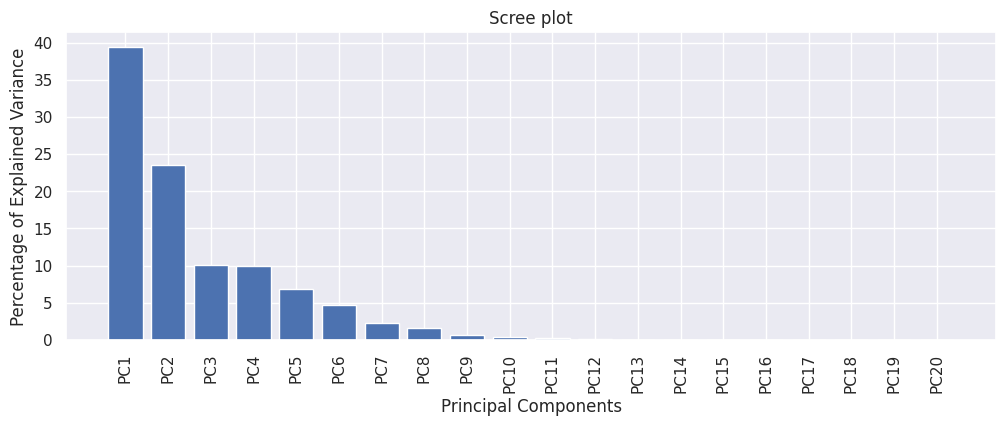

In [6]:
x = df_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

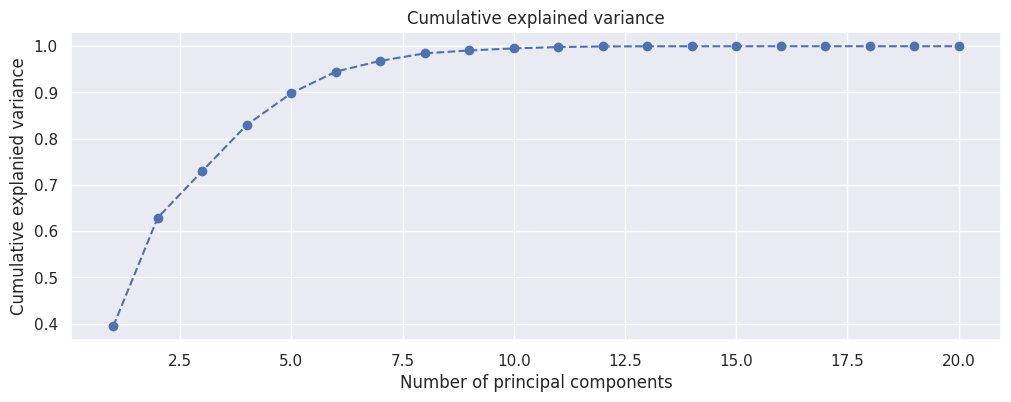

In [7]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [8]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_cl = pd.concat([df_cl, principal_components_df], axis=1)

### Load unknown dataset and PCA

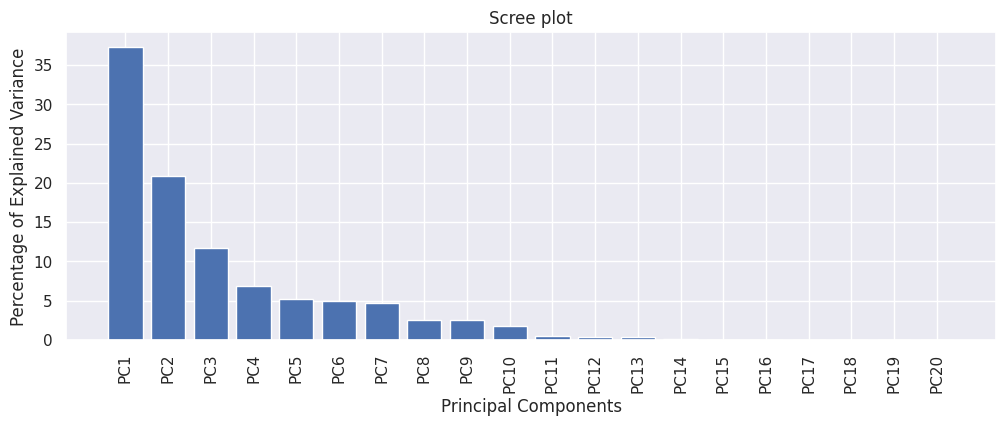

In [9]:
# x = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
x = df_un_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
       'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
       'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
       'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
       'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
       'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
       'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
       'st_documentary', 'st_reboot', 'st_based on a true story',
       'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)
# Fit and scale data
x = StandardScaler().fit_transform(x)
pca = PCA()

# Fit and scale
principal_components = pca.fit_transform(x)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
labels = [f'PC{x}' for x in range(1, len(per_var)+1)]

principal_df = pd.DataFrame(data = principal_components, columns = labels)

final_df = pd.concat([principal_df, df_cl[['oscar_winners']]], axis = 1)

sns.set_theme()
plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
plt.bar(x=range(len(x[0])), height=per_var,  tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

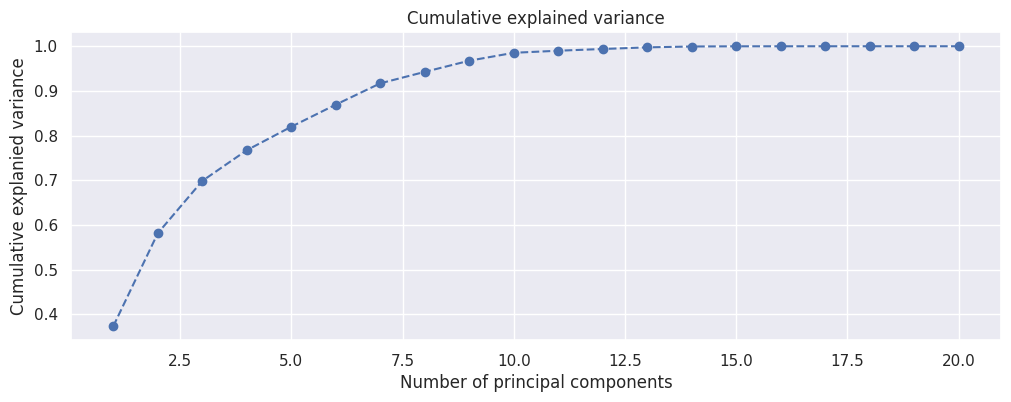

In [10]:
sns.set_theme()
plt.figure(figsize= (12,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explanied variance')
plt.show()

In [11]:
# Calculate PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(x)

# Concat PCA results to dataframe
principal_components_df = pd.DataFrame(principal_components)
principal_components_df.columns = [f'PC{x+1}' for x in principal_components_df.columns]
df_un_cl = pd.concat([df_un_cl, principal_components_df], axis=1)

In [12]:
# Select PCA components
# df = df_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'oscar_winners']]
# df = df_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
#        'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
#        'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
#        'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
#        'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
#        'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
#        'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
#        'st_documentary', 'st_reboot', 'st_based on a true story',
#        'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

df = df_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail'], axis=1)

train_datasets, test_dataset = build_resampled_datasets(df, test_ratio=0.2)

In [13]:
unknown_for_classification = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)

## ADA Boost

Define results dict

In [14]:
results = {}

In [15]:
#Ada boost
results['ADA'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['ADA'][sampling] = []

    model = AdaBoostClassifier(random_state=1)

    # Full search
#     parameters = {
#             'n_estimators': range(10, 2001, 10),
#     }
    parameters = {
            'n_estimators': [20,50,80,100],
    }


    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['ADA'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best parameters for default: {'n_estimators': 50}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for upsampled: {'n_estimators': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for downsampled: {'n_estimators': 80}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for SMOTE: {'n_estimators': 100}


In [16]:
# params= {}
# for sampling in results['ADA']:
#     params[sampling] = results['ADA'][sampling][0]['params'] 

# with open("./ADA.json", 'w') as f:
#     json.dump(params, f)    

## Gradient Boost

In [17]:
# Gradient boosting classifier
results['GRB'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['GRB'][sampling] = []

    model = GradientBoostingClassifier(random_state=1) 

    # Full search
    # parameters = {
    #     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #     "min_samples_split": np.linspace(0.1, 0.5, 12),
    #     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    #     "max_depth":[3,5,8],
    #     "max_features":["log2","sqrt"],
    #     "criterion": ["friedman_mse",  "squared_error"],
    #     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    #     "n_estimators":[10]
    # }

    # parameters = {
    #       "criterion": ["friedman_mse"], 
    #      "learning_rate": [0.2], 
    #      "max_depth": [3,5], 
    #      "max_features": ["log2"], 
    #      "min_samples_leaf": [0.1], 
    #      "min_samples_split": [0.1,0.39, 0.245],
    #      "n_estimators": [10], 
    #      "subsample": [0.9, 1.0]
    # }

    parameters = {
        #  "criterion": ["friedman_mse"], 
        #  "learning_rate": [0.2], 
        #  "max_depth": [3,5], 
        #  "n_estimators": [10],
    }


    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['GRB'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for default: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for upsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for downsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SMOTE: {}


In [18]:
# params= {}
# for sampling in results['GRB']:
#     params[sampling] = results['GRB'][sampling][0]['params'] 

# with open("./test.json", 'w') as f:
#     json.dump(params, f)    

## Decision Tree

In [19]:
# Decision tree classifier
results['DT'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['DT'][sampling] = []

    model = DecisionTreeClassifier(random_state=1)    

    parameters = {
        # "criterion": ['gini', 'entropy'],
        # "splitter": ['best', 'random'],
        # "max_depth": [10,9,8],
        # 'min_samples_split' : [2,8],
        # 'min_samples_leaf' : [1,2],
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['DT'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for default: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for upsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for downsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SMOTE: {}


In [20]:
# params= {}
# for sampling in results['DT']:
#     params[sampling] = results['DT'][sampling][0]['params'] 

# with open("./DT.json", 'w') as f:
#     json.dump(params, f)   

## Random Forest

In [21]:
# Random forest
results['RF'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['RF'][sampling] = []

    model = RandomForestClassifier(n_jobs=-1, random_state=1)

    # parameters = {
    #     'bootstrap': [True, False],
    #     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #     'max_features': ['log2', 'sqrt', None],
    #     'min_samples_leaf': [1, 2, 4],
    #     'min_samples_split': [2, 5, 10],
    #     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    # }

    parameters = {
        # 'bootstrap': [False],
        # 'max_depth': [10, 20],
        # 'max_features': ['log2'],
        # 'min_samples_leaf': [1, 4],
        # # 'min_samples_split': [2],
        # 'n_estimators': [200, 400, 600, 1400]
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['RF'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for default: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for upsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for downsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SMOTE: {}


In [22]:
# params= {}
# for sampling in results['RF']:
#     params[sampling] = results['RF'][sampling][0]['params'] 

# with open("./RF.json", 'w') as f:
#     json.dump(params, f)   

## K-Nearest Neighbors

Select features

Train and test

In [23]:
results['KNN'] = {}
for sampling, dataset in zip(train_datasets.keys(), train_datasets.values()):

    results['KNN'][sampling] = []

    model = KNeighborsClassifier(n_jobs=-1)

    parameters = {
        # "n_neighbors": [2,8,9],
        # "weights": ['uniform', 'distance'],
        # "algorithm" : ['auto'],
        # 'leaf_size' : range(1, 201, 10)
    }

    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1)

    X_train, y_train = dataset.drop('oscar_winners', axis=1), dataset[['oscar_winners']].values.ravel()
    X_test, y_test = test_dataset.drop('oscar_winners', axis=1), test_dataset[['oscar_winners']].values.ravel()     

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0.0)

    results['KNN'][sampling].append({
                # 'fold' : str(i),
                'report' : report,
                'preds' : y_pred,
                'true' : y_test,
                'X_train' : X_train,
                'y_train' : y_train,
                'params' : grid_search.best_params_
        })
    
    print(f'Best parameters for {sampling}: {grid_search.best_params_}')

    

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for default: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for upsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for downsampled: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for SMOTE: {}


In [24]:
# params= {}
# for sampling in results['KNN']:
#     params[sampling] = results['KNN'][sampling][0]['params'] 

# with open("./KNN.json", 'w') as f:
#     json.dump(params, f)    

## Plot results

Classification reports

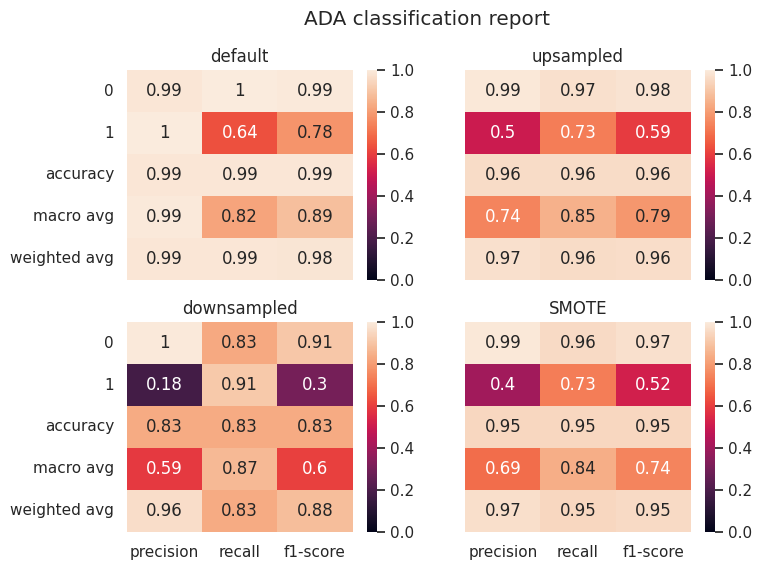

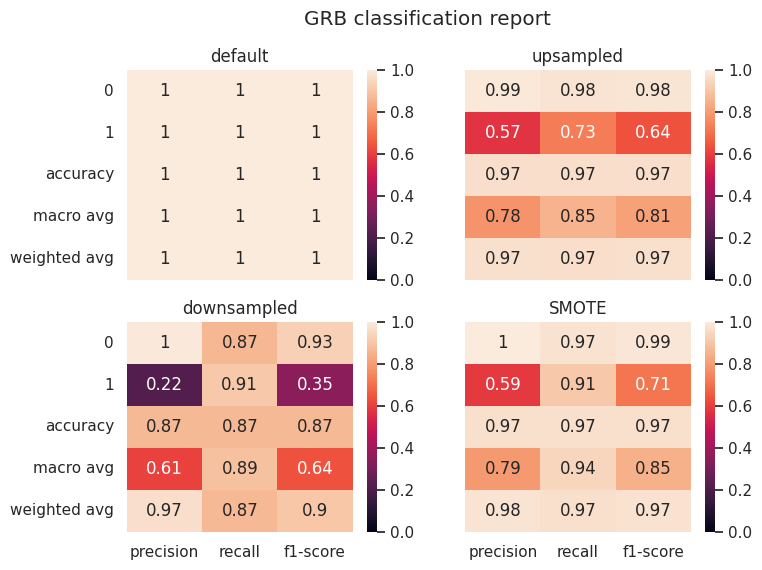

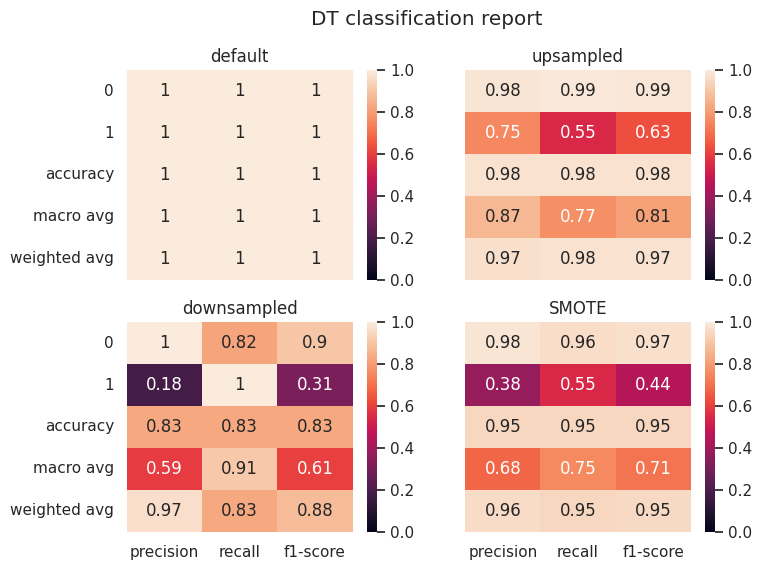

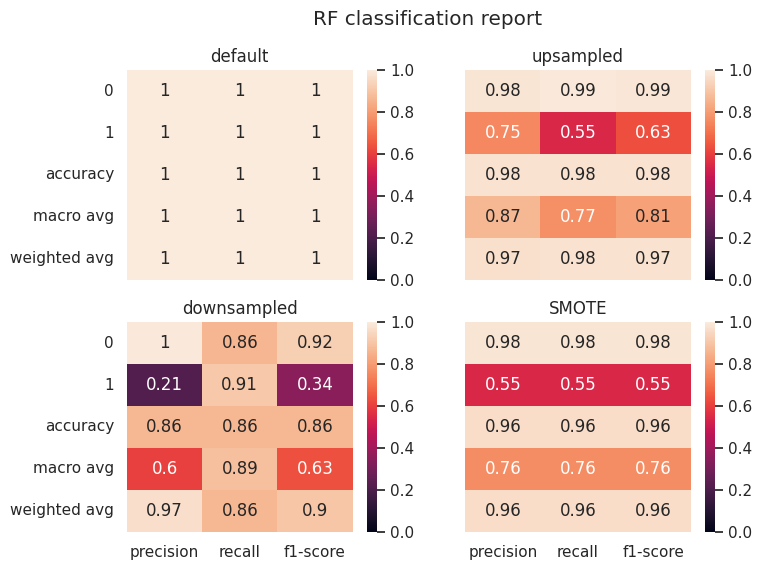

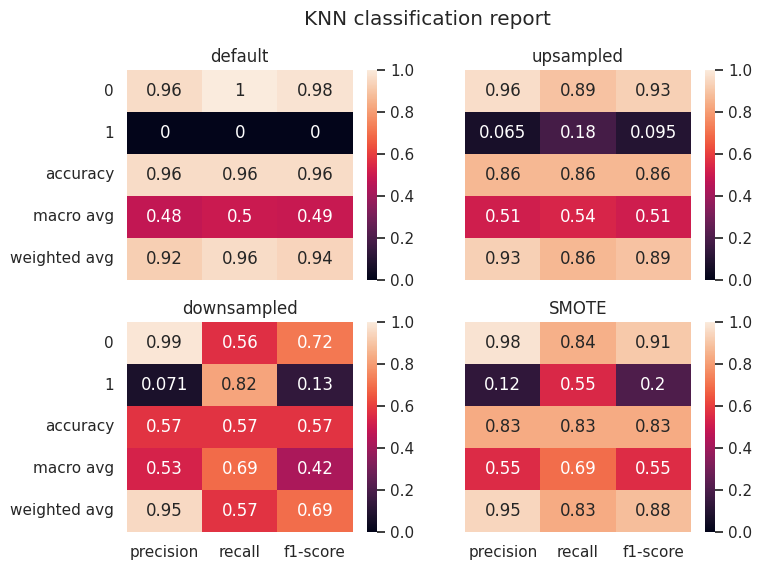

In [25]:
plot_classification_reports_averages(results, 'ADA')
plot_classification_reports_averages(results, 'GRB')
plot_classification_reports_averages(results, 'DT')
plot_classification_reports_averages(results, 'RF')
plot_classification_reports_averages(results, 'KNN')

ROC Curves

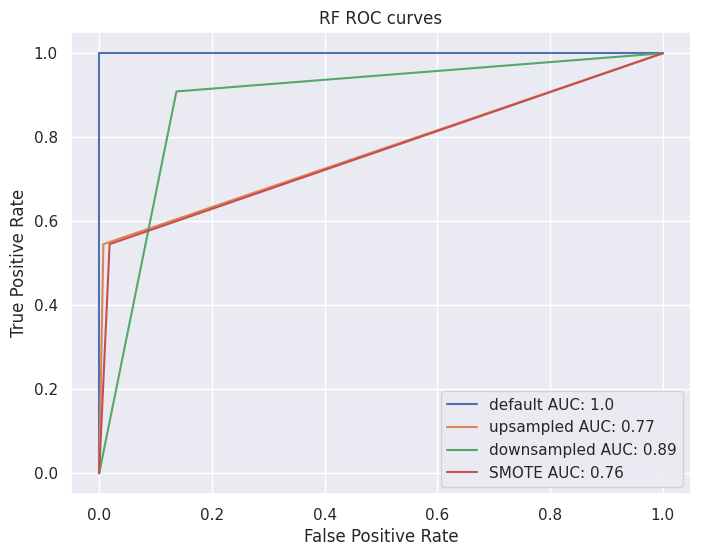

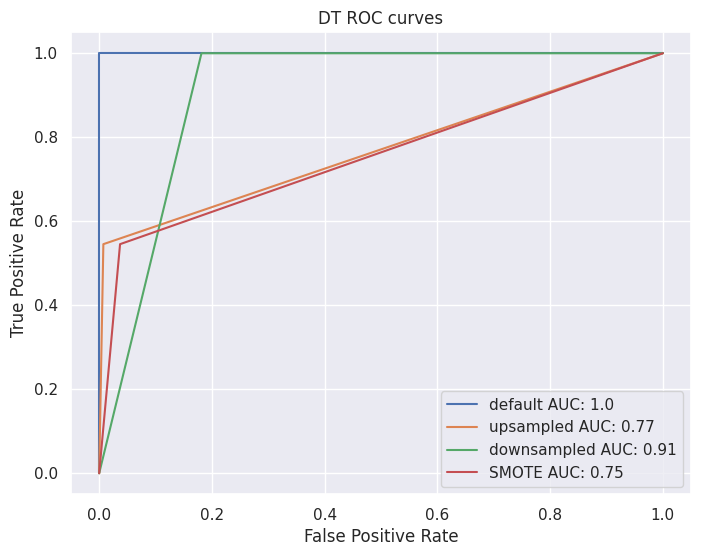

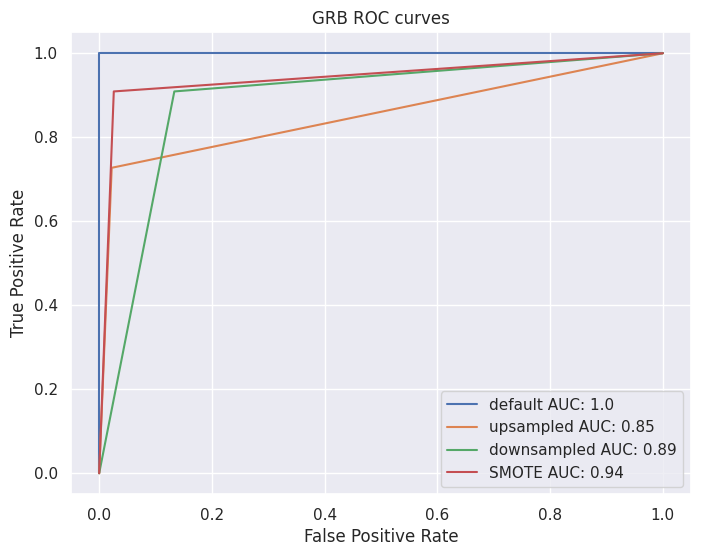

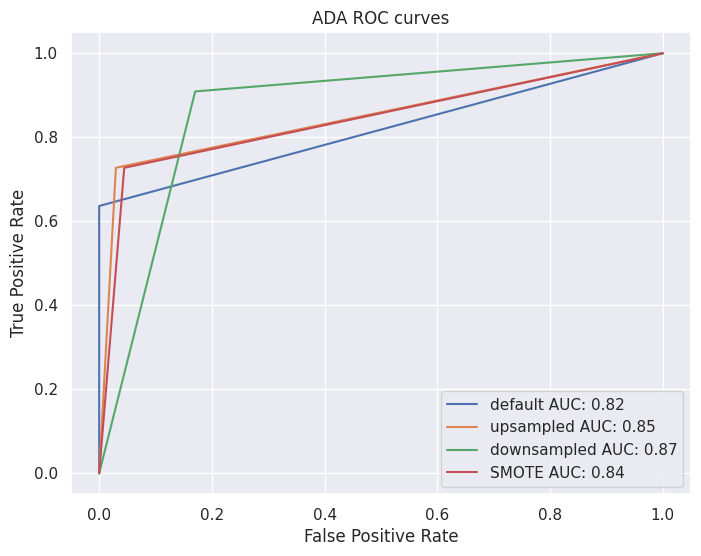

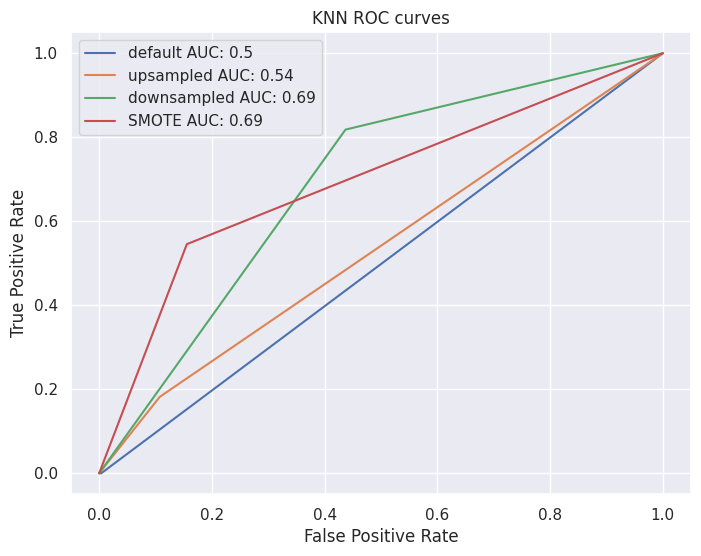

In [26]:
best_f1_ada = best_f1_score_for_each_sampling_method(results, 'ADA')
best_f1_grb = best_f1_score_for_each_sampling_method(results, 'GRB')
best_f1_dt = best_f1_score_for_each_sampling_method(results, 'DT')
best_f1_rf = best_f1_score_for_each_sampling_method(results, 'RF')
best_f1_knn = best_f1_score_for_each_sampling_method(results, 'KNN')
plot_roc_curves(best_f1_rf, 'RF')
plot_roc_curves(best_f1_dt, 'DT')
plot_roc_curves(best_f1_grb, 'GRB')
plot_roc_curves(best_f1_ada, 'ADA')
plot_roc_curves(best_f1_knn, 'KNN')

Confusion Matrices

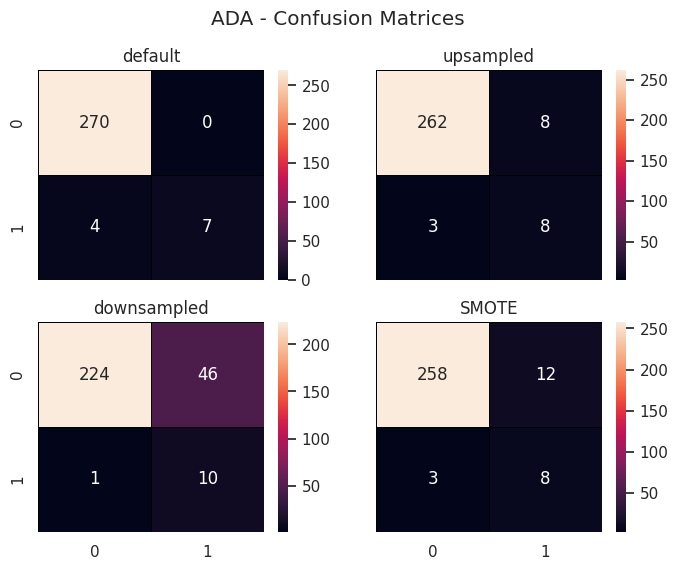

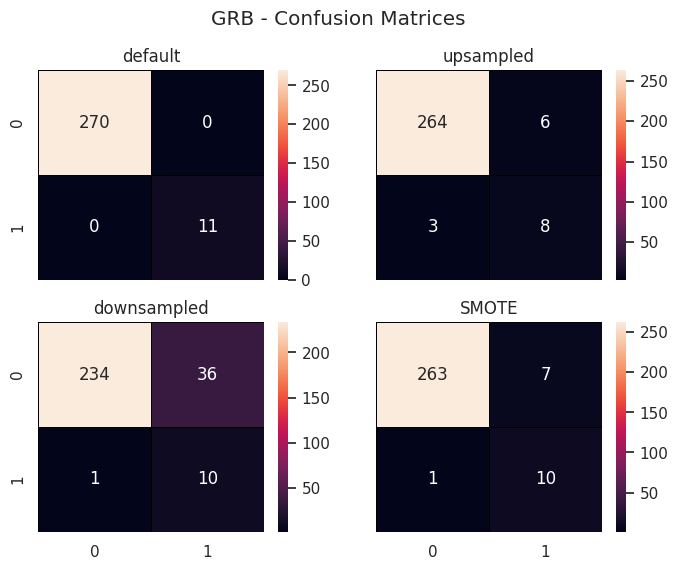

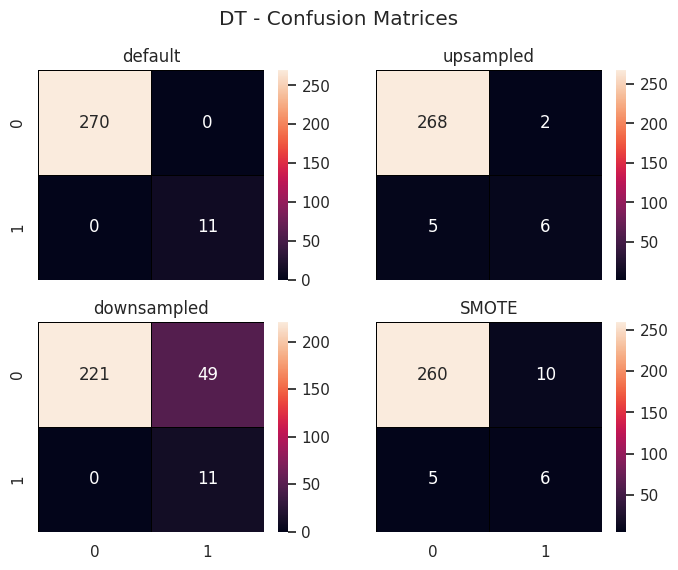

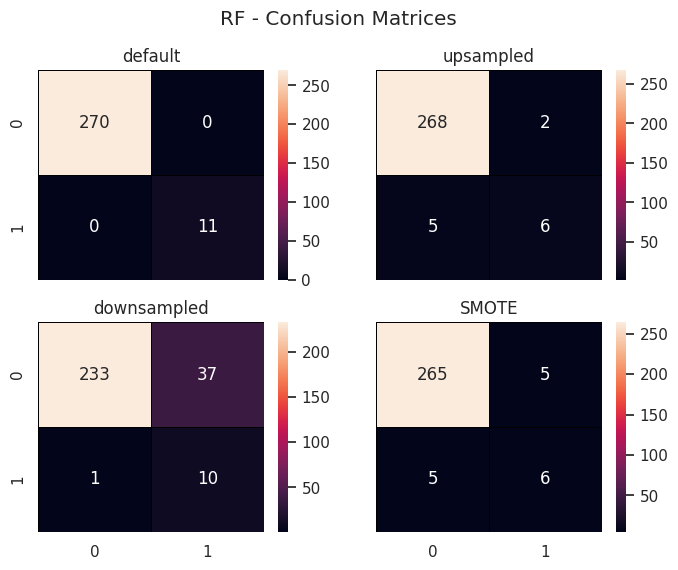

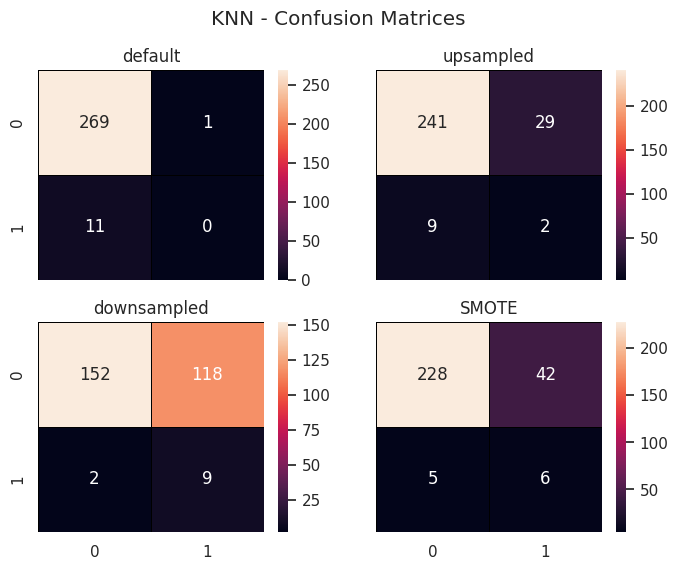

In [27]:
plot_confusion_matrices(best_f1_ada, 'ADA')
plot_confusion_matrices(best_f1_grb, 'GRB')
plot_confusion_matrices(best_f1_dt, 'DT')
plot_confusion_matrices(best_f1_rf, 'RF')
plot_confusion_matrices(best_f1_knn, 'KNN')

# 6. Predictions on unknown dataset

#### Select unknown dataset features

In [488]:
len(predictions[predictions['OSCAR'] == 1])

16

In [487]:
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,7,16,82,3,75


In [464]:
X = unknown_for_classification

# X = df_un_cl[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]


# X = df_un_cl.drop(['gen_fantasy', 'gen_thriller', 'gen_animation', 'gen_family',
#        'gen_horror', 'gen_sports', 'gen_fanstasy', 'gen_holiday',
#        'gen_documentary', 'gen_period', 'gen_romance', 'gen_biography',
#        'gen_suspense', 'gen_history', 'gen_mystery', 'gen_musical',
#        'gen_crime', 'gen_sci-fi', 'gen_comedy', 'gen_action', 'gen_western',
#        'gen_war', 'gen_horror/mystery', 'gen_adventure', 'gen_drama',
#        'st_sequel', 'st_semi-sequel', 'st_remake', 'st_original screenplay',
#        'st_documentary', 'st_reboot', 'st_based on a true story',
#        'st_adaptation', 'st_prequel','film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)

# X = df_un_cl.drop(['film', 'year', 'distributor', 'imdb_rating', 'imdb_vs_rt_disparity', 'release_date_(us)', 'oscar_detail', 'oscar_winners'], axis=1)

### 6.1 ADA Boost

In [465]:
best_overall_ada = max(best_f1_ada.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_ada['params']
# params = results['ADA']['SMOTE'][0]['params']
# params = results['ADA']['default'][0]['params']


# From gridsearch - DEFAULT
# params = {"n_estimators": 100}

# best_overall_ada = {}
# best_overall_ada['X_train'] = train_datasets['default'].drop('oscar_winners', axis=1)
# best_overall_ada['y_train'] = train_datasets['default']['oscar_winners'].values.ravel()

In [466]:
model = AdaBoostClassifier(**params)

model.fit(best_overall_ada['X_train'], best_overall_ada['y_train'])
un_preds = model.predict(X)

df_un_orig[f'ADA'] = pd.DataFrame(un_preds)
ada_n_predicted_oscars = len(df_un_orig[df_un_orig['ADA'] == 1])
ada_n_predicted_oscars

7

### 6.2 Gradient Boost

In [467]:
best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_grb['params']
# params = results['GRB']['SMOTE'][0]['params']
# params = results['GRB']['default'][0]['params']

# From gridsearch - UPSAMPLED
# params = {"criterion": "friedman_mse",
#           "learning_rate": 0.2,
#           "max_depth": 5,
#           "max_features": "log2",
#           "min_samples_leaf": 0.1,
#           "min_samples_split": 0.1,
#           "n_estimators": 10,
#           "subsample": 1.0}

# best_overall_grb = {}
# best_overall_grb['X_train'] = train_datasets['upsampled'].drop('oscar_winners', axis=1)
# best_overall_grb['y_train'] = train_datasets['upsampled']['oscar_winners'].values.ravel()

params

{}

In [468]:
# best_overall_grb = max(best_f1_grb.values(), key=lambda a:a['report']['1']['f1-score'])

model = GradientBoostingClassifier(**params)

model.fit(best_overall_grb['X_train'], best_overall_grb['y_train'])
un_preds = model.predict(X)

df_un_orig[f'GRB'] = pd.DataFrame(un_preds)
grb_n_predicted_oscars= len(df_un_orig[df_un_orig['GRB'] == 1])
grb_n_predicted_oscars

16

### 6.3 Decision Tree

In [469]:
best_overall_dt = max(best_f1_dt.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_dt['params']
# params = results['DT']['SMOTE'][0]['params']
# params = results['DT']['default'][0]['params']

# params = {'criterion': 'gini',
#  'max_depth': 10,
#  'min_samples_leaf': 2,
#  'min_samples_split': 8,
#  'splitter': 'random'}
# params

# best_overall_dt = {}
# best_overall_dt['X_train'] = train_datasets['default'].drop('oscar_winners', axis=1)
# best_overall_dt['y_train'] = train_datasets['default']['oscar_winners'].values.ravel()

In [470]:
model = DecisionTreeClassifier(**params)

model.fit(best_overall_dt['X_train'], best_overall_dt['y_train'])
un_preds = model.predict(X)

df_un_orig[f'DT'] = pd.DataFrame(un_preds)
dt_n_predicted_oscars = len(df_un_orig[df_un_orig['DT'] == 1])
dt_n_predicted_oscars

82

### 6.4 Random Forest

In [471]:
best_overall_rf = max(best_f1_rf.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_rf['params']
# params = results['RF']['SMOTE'][0]['params']
# params = results['RF']['default'][0]['params']
# params = {'bootstrap': False,
#  'max_depth': 10,
#  'max_features': 'log2',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 600}

# params

# best_overall_rf = {}
# best_overall_rf['X_train'] = train_datasets['default'].drop('oscar_winners', axis=1)
# best_overall_rf['y_train'] = train_datasets['default']['oscar_winners'].values.ravel()

In [472]:
model = RandomForestClassifier(**params)

model.fit(best_overall_rf['X_train'], best_overall_rf['y_train'])
un_preds = model.predict(X)

df_un_orig[f'RF'] = pd.DataFrame(un_preds)
rf_n_predicted_oscars = len(df_un_orig[df_un_orig['RF'] == 1])
rf_n_predicted_oscars

3

### 6.5 K-Nearest Neighbors

In [473]:
best_overall_knn = max(best_f1_knn.values(), key=lambda a:a['report']['1']['f1-score'])
params = best_overall_knn['params']
# params = results['KNN']['SMOTE'][0]['params']
# params = results['KNN']['default'][0]['params']
# params = {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 9, 'weights': 'distance'}
# params

# best_overall_knn = {}
# best_overall_knn['X_train'] = train_datasets['default'].drop('oscar_winners', axis=1)
# best_overall_knn['y_train'] = train_datasets['default']['oscar_winners'].values.ravel()

In [474]:
model = KNeighborsClassifier(**params)
model.fit(best_overall_knn['X_train'], best_overall_knn['y_train'])

un_preds = model.predict(X)
preds_df = pd.DataFrame(un_preds)
df_un_orig[f'KNN'] = preds_df

knn_n_predicted_oscars = len(df_un_orig[df_un_orig['KNN'] == 1])
knn_n_predicted_oscars

75

## Show all model predictons

In [475]:
#['ADA', 'GRB', 'DT','RF', 'KNN']
n_oscar_preds = pd.DataFrame([[ada_n_predicted_oscars, grb_n_predicted_oscars, dt_n_predicted_oscars, rf_n_predicted_oscars, knn_n_predicted_oscars]], columns=['ADA', 'GRB', 'DT','RF', 'KNN'])

Number of predictions per model

In [476]:
n_oscar_preds

,ADA,GRB,DT,RF,KNN
0,7,16,82,3,75


Detailed predictions view

In [477]:
df_un_orig[(df_un_orig['ADA'] == 1) | (df_un_orig['GRB'] == 1) | (df_un_orig['DT'] == 1) | (df_un_orig['RF'] == 1) | (df_un_orig['KNN'] == 1)][['ID','ADA', 'GRB', 'DT','RF', 'KNN']]

,ID,ADA,GRB,DT,RF,KNN
4,5,0,0,1,0,0
7,8,0,1,1,0,0
11,12,0,0,1,0,0
15,16,0,0,1,0,0
19,20,0,0,1,0,0
...,...,...,...,...,...,...
543,544,0,0,1,0,0
547,548,0,1,0,0,0
551,552,0,0,1,0,1
556,557,0,0,0,0,1


Select final oscar prediction criteria

In [478]:
# Majority vote
DECISION_THRESHOLD = 3
predictions = df_un_orig[['ID', 'ADA', 'GRB', 'DT','RF', 'KNN']]
predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)
len(predictions[predictions['OSCAR'] == 1])

/tmp/ipykernel_2984/2843540888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['OSCAR'] = predictions.apply(lambda row: 1 if (row['ADA'] + row['GRB'] + row['DT'] + row['RF'] + row['KNN'] >= DECISION_THRESHOLD) else 0, axis=1)


5

In [489]:
predictions[predictions['OSCAR'] == 1]

,ID,OSCAR
7,8,1
44,45,1
132,133,1
146,147,1
216,217,1
280,281,1
298,299,1
307,308,1
390,391,1
412,413,1


In [480]:
# Use only best F1 score models
# predictions['ID'] = df_un_orig[['ID']]
# predictions['OSCAR'] = df_un_orig[['ADA', 'RF', 'KNN']].apply(lambda row: 1 if (row['ADA'] + row['RF'] + row['KNN'] == 3) else 0, axis=1)
# len(predictions[predictions['OSCAR'] == 1])

In [481]:
# old = pd.read_csv('predictions_old.csv')
# old[old['OSCAR'] == 1]

Overall oscar prediction number

In [490]:
print(f"Unkn dataset predicted oscar ratio: {len(predictions[predictions['OSCAR'] == 1]) / len(predictions) * 100:.2f}% | Testing dataset oscar prediction ratio: {len(df_cl[df_cl['oscar_winners'] == 1]) / len(df_cl) * 100:.2f}%")

Unkn dataset predicted oscar ratio: 2.83% | Testing dataset oscar prediction ratio: 3.99%


In [483]:
# Save file
# predictions = predictions.drop(['DT','ADA', 'GRB', 'RF', 'KNN'], axis=1)
# predictions.to_csv('./predictions_new.csv', index=False)

In [484]:
predictions

,ID,ADA,GRB,DT,RF,KNN,OSCAR
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,1,0,0,0
...,...,...,...,...,...,...,...
560,561,0,0,0,0,0,0
561,562,0,0,0,0,0,0
562,563,0,0,0,0,0,0
563,564,0,0,1,0,0,0


In [485]:
predictions

,ID,ADA,GRB,DT,RF,KNN,OSCAR
0,1,0,0,0,0,0,0
1,2,0,0,0,0,0,0
2,3,0,0,0,0,0,0
3,4,0,0,0,0,0,0
4,5,0,0,1,0,0,0
...,...,...,...,...,...,...,...
560,561,0,0,0,0,0,0
561,562,0,0,0,0,0,0
562,563,0,0,0,0,0,0
563,564,0,0,1,0,0,0


In [486]:
# predictions = predictions.drop(['DT','ADA', 'RF', 'KNN'], axis=1)
# predictions['OSCAR'] = predictions['GRB']
# predictions = predictions.drop(['GRB'], axis =1)
# predictions.to_csv('./predictions_GRB.csv', index=False)